# Performance analysis of PrimConsTree

## Simulation design

Random trees are generated with the Hybrid Sim tool, using evry combinations of K, N, C parameters defined when running eval.py.

For each combination of K, N and C, we generated multiple batchs of input trees. We then computed the **PrimConsTree consensus tree**, the **previous PrimConsTree** and the **extended majority rule** for each batch. Additionally, we collected the following metrics on each batch:
- Average RF distance between the input trees and the consensus
- Average BSD distance between the input trees and the consensus
- Execution time to build the consensus tree

In [1]:
import json
import logging
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from itertools import product

RESULTS_FILE = "../outputs/eval/HS-FINAL-Lamb.json"

with open(RESULTS_FILE, "r") as f:
    data = json.load(f)

matplotlib.rcParams.update(matplotlib.rcParamsDefault)
matplotlib.rc('text', usetex = True)

algs = {"maj_plus": "Majority rule +", "pct": "PrimConsTree V2", "maj": "Ext. majority rule", "freq": "Frequency difference", "old_pct": "PrimConsTree V1"}
dists = {"kcdist": r"Kendall-Colijn distance", "kcdist0": r"Kendall-Colijn distance", "kcdist0.5": r"Kendall-Colijn distance", "kcdist1": r"Kendall-Colijn distance","tdist": "Triplet distance", "qdist": "Quartet distance", "bsd": "Branch score distance", "duration": "Duration (seconds)", "rf": "Robinson and Foulds distance"}
actual_algs = {a: algs[a] for a in algs if a in data[0]}

formated = []
for d, a in product(data, actual_algs.keys()):
    entry = {"algorithm": algs[a], "n": d["n"], "k": d["k"], "c": d["c"], "lambda":d["lambda"]}
    for metric in dists:
        if metric in d[a]:
            entry[metric] = d[a][metric]
    formated.append(entry)

df = pd.DataFrame(formated)

In [3]:
def set_y_label(metric, ax):
    ax.set_ylabel(dists[metric])

def set_x_label(x, ax):
    if x == "k":
        ax.set_xlabel(r"Number of trees ($\mathit{k}$)")
    elif x == "n":
        ax.set_xlabel(r"Number of leaves ($\mathit{n}$)")
    elif x == "c":
        ax.set_xlabel(r"Coalescence rate ($\mathit{c}$)")
    elif x == "lambda":
        ax.set_xlabel(r"$\lambda$")

def plot_metric(metric, xs, algs):
    fig, axes = plt.subplots(nrows=1, ncols=len(xs), figsize=(20/3*len(xs), 5))
    algs_data = df[df["algorithm"].isin(algs)]
    for ax, x in zip(axes, xs):
        sns.lineplot(x=x, y=metric, hue="algorithm", data=algs_data, ax=ax, markers=True, style="algorithm", dashes=False)
        set_y_label(metric, ax)
        set_x_label(x, ax)
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles=handles, labels=labels)  
    return fig, axes

def figure(metrics, xs, algs):
    fig, axes = plt.subplots(nrows=len(xs), ncols=len(metrics), figsize=(6*len(metrics), 5*len(xs)))
    algs_data = df[df["algorithm"].isin(algs)]
    for i, x in enumerate(xs):
        for j, metric in enumerate(metrics):
            ax = axes[i][j]
            sns.lineplot(x=x, y=metric, hue="algorithm", data=algs_data, ax=ax, markers=True, style="algorithm", dashes=False, errorbar=None)
            set_y_label(metric, ax)
            set_x_label(x, ax)
            handles, labels = ax.get_legend_handles_labels()
            ax.legend(handles=handles, labels=labels)  
    return fig, axes

In [ ]:
fig, axes = figure(["kcdist0", "kcdist0.5", "kcdist1"], ["k", "n", "c"], [algs["pct"], algs["old_pct"], algs["maj"], algs["freq"]])           
axes[0][0].legend(loc='upper left', bbox_to_anchor=(0.575, 0.55))
axes[0][1].legend(loc='upper left', bbox_to_anchor=(0.575, 0.75))
fig.text(0.3, 0.915, r'$\lambda = 0$', ha='center', va='center', fontsize=15)
fig.text(0.725, 0.915, r'$\lambda = 0.5$', ha='center', va='center', fontsize=15)
plt.show()
#plt.savefig('../img/KC_Figure.pdf', dpi=300)

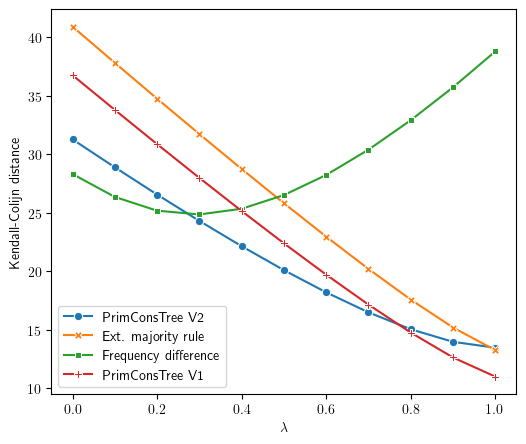

In [4]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6, 5))
ax = axes
sns.lineplot(x="lambda", y="kcdist", hue="algorithm", data=df, ax=ax, markers=True, style="algorithm", dashes=False, errorbar=None)
set_y_label("kcdist", ax)
set_x_label("lambda", ax)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=labels)  

#plt.show()
plt.savefig('../img/Lamb_Figure.pdf', dpi=300)

## 1. Average RF for varying k, n, c

Robinson and Foulds distance is computed using the ete3 built in method. Given a batch of input trees, the RF distance is calculated beteween each input tree and the consensus tree and it is normalized between 0 and 1. Then the normalized RF distances are averaged in one value.

In [ ]:
_, axes = plot_metric("rf", ["k", "n", "c"], [algs["pct"], algs["old_pct"], algs["maj"], algs["freq"], algs["maj_plus"]])
axes[0].legend(loc='upper left', bbox_to_anchor=(0.6, 0.85))
plt.show()
#plt.savefig('../img/rf.pdf', dpi=300)

## KC lambda = 0

In [ ]:
_, axes = plot_metric("kcdist0", ["k", "n", "c"], [algs["pct"], algs["old_pct"], algs["maj"], algs["freq"], algs["maj_plus"]])
plt.show()
#plt.savefig('../img/kc_lamb0_confinter.pdf', dpi=300)

## KC lambda = 0.5

In [ ]:
_, axes = plot_metric("kcdist0.5", ["k", "n", "c"], [algs["pct"], algs["old_pct"], algs["maj"], algs["freq"], algs["maj_plus"]])
plt.show()
#plt.savefig('../img/kc_lamb05_confinter.pdf', dpi=300)

## 1.5 Average Triplet dist

Measured with the [tqdist](https://www.birc.au.dk/~cstorm/software/tqdist/) tool. The average triplet distance between the consensus tree and every input tree is measured.

In [ ]:
plot_metric("tdist", ["k", "n", "c"], [algs["pct"], algs["maj"], algs["freq"], algs["old_pct"]])
plt.show()
#plt.savefig('../img/triplet.pdf', dpi=300)

## 1.5 Average Quartet dist

Measured with the [tqdist](https://www.birc.au.dk/~cstorm/software/tqdist/) tool. The average quartet distance between the consensus tree and every input tree is measured.

In [ ]:
plot_metric("qdist", ["k", "n", "c"], [algs["pct"], algs["maj"], algs["freq"], algs["old_pct"]])
plt.show()
#plt.savefig('../img/quartet.pdf', dpi=300)

## 2. Average Normalized BSD for varying k, n

Given 2 trees, the normalized BSD <a name="cite_ref-1"></a>[<sup>[1]</sup>](#cite_note-1) is calculated the following way:

$$ BSD(T, T') = \sqrt{\sum_{i} (\frac{b_i}{size(T)} - \frac{b_i'}{size(T')})^2} $$

Where $B = \{b_1, b_2, ..., b_n\}$ is the set of **branch lengths** corresponding to each bipartition in the tree T and $B' = \{b_1', b_2', ..., b_n'\}$ is the set of **branch lengths** corresponding to the same bipartitions in the tree T'. When a bipartition is present in one tree but not in the other, the length of the missing bipartition is considered to be 0. Size(T) denote the sum of all bipartitions length in the tree T, dividing by this value provide a relative distance between the tree, instead of an absolute distance biased by the size of the trees.

<a name="cite_note-1"></a>[[1]](#cite_ref-1) : M K Kuhner, J Felsenstein, A simulation comparison of phylogeny algorithms under equal and unequal evolutionary rates. Molecular Biology and Evolution, Volume 11, Issue 3, May 1994, Pages 459–468,

In [ ]:
plot_metric("bsd", ["k", "n", "c"], [algs["pct"], algs["maj"], algs["freq"], algs["maj_plus"]])
plt.show()
#plt.savefig('../img/bsd.eps', dpi=300)

## 3. Execution time for varying k, n, c

For each batch of input trees, the consensus methods are executed 10 times, and the minimum value is retained.

In [ ]:
plot_metric("duration", ["k", "n", "c"], [algs["pct"], algs["maj"], algs["freq"]])
plt.show()
#plt.savefig('../img/duration.pdf', dpi=300)